In [1]:
import utility
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
# mpl.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'serif'  # Use Computer Modern fonts
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts}'


contri = ['spearman', 'mse']

# Define color palette
palette = list(sns.color_palette("Set2")[:3]) + ['yellow']

# Define the custom orders
SYSTEM_ORDER = ["A2A"]
FORCE_FIELD_ORDER = ['espaloma-0.3.1', 'gaff-2.11', 'openff-2.0.0', 'Deflorian2020']
FF_NAME = {
    'espaloma-0.3.1': 'Espaloma', 
    'gaff-2.11': 'GAFF',
    'openff-2.0.0': 'OpenFF',
    'Deflorian2020': 'Deflorian et al. 2020',
}
SYSTEM_NAME = {
    "A2A": "A2A",
}


def to_latex(string):
    try:
        return r"$\mathrm{" + string.replace("_", r"\_").replace("-", r"-").replace(" ", r"\ ") + r"}$"
    except:
        raise Exception(string)





def plot_stats(ax, data, contribution='spearman', legend = 'auto'):
    dat2work = data.copy()
    
    SYSTEM_ORDER_LATEX = [to_latex(SYSTEM_NAME[s]) for s in SYSTEM_ORDER]
    FORCE_FIELD_ORDER_LATEX = [to_latex(FF_NAME[f]) for f in FORCE_FIELD_ORDER]
    
    values = dat2work[contribution].apply(utility.get_numerical_values)
    values = np.array(list(values.values))
    
    ci_low = []
    ci_high = []
    nominal_value = []
    for v, l, h in values:
        if v:
            nominal_value.append(v)
            ci_low.append(v - l)
            ci_high.append(h - v)
        else:
            nominal_value.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)

    dat2work['ci_low'] = ci_low
    dat2work['ci_high'] = ci_high
    dat2work[contribution] = nominal_value
    
    # dat2work['ci_low'] = values[:,0] - values[:,1]
    # dat2work['ci_high'] = values[:,2] - values[:,0]
    # dat2work['value'] = values[:,0]

    
    dat2work['source'] = pd.Categorical(
        dat2work['source'].replace(SYSTEM_NAME).map(to_latex), categories=SYSTEM_ORDER_LATEX, ordered=True
    )
    dat2work['force_field'] = pd.Categorical(
        dat2work['force_field'].replace(FF_NAME).map(to_latex), categories=FORCE_FIELD_ORDER_LATEX, ordered=True
    )

    # Sort the DataFrame based on the custom orders
    dat2work = dat2work.sort_values(by=['source', 'force_field']).reset_index(drop=True)

    bar_plot = sns.barplot(
        data=dat2work,
        x="source",
        y=contribution,
        hue='force_field',
        width=0.3,
        ax=ax,
        legend=legend,
        hue_order=FORCE_FIELD_ORDER_LATEX,
        palette=palette,
        order=SYSTEM_ORDER_LATEX
    )

    # Those are the patch used on the legend and attached at the end
    num_unique_ff = len(dat2work["force_field"].unique())
    # [:-num_unique_ff] ensures that only the patches of the real bars are considered
    if legend:
        bar_positions = sorted([patch.get_x() + patch.get_width() / 2 for patch in bar_plot.patches[:-num_unique_ff]])
    else:
        bar_positions = sorted([patch.get_x() + patch.get_width() / 2 for patch in bar_plot.patches])
    dat2work.dropna(inplace=True)
    ax.errorbar(
        x=bar_positions,  # Position of the bar
        y=dat2work[contribution],
        yerr=[dat2work['ci_low'], dat2work['ci_high']],
        fmt='none',  # No marker
        c='gray',
        capsize=5
    )

    if contribution == 'pearson':
        ax.set(
            ylabel=r'$\rho$'
        )
    if contribution == 'spearman':
        ax.set(
            ylabel=r'$r_S$'
        )
    if contribution == 'kendall':
        ax.set(
            ylabel=r'$\tau$'
        )
        
    ax.set(xlabel='')


def plot_ff(ax, data, contribution, legend = None):
    
    dat2work = data.copy()
    
    SYSTEM_ORDER_LATEX = [to_latex(SYSTEM_NAME[s]) for s in SYSTEM_ORDER]
    FORCE_FIELD_ORDER_LATEX = [to_latex(FF_NAME[f]) for f in FORCE_FIELD_ORDER]
    
    dat2work['source'] = pd.Categorical(
        dat2work['source'].replace(SYSTEM_NAME).map(to_latex), categories=SYSTEM_ORDER_LATEX, ordered=True
    )
    dat2work['force_field'] = pd.Categorical(
        dat2work['force_field'].replace(FF_NAME).map(to_latex), categories=FORCE_FIELD_ORDER_LATEX, ordered=True
    )
    
    # Sort the DataFrame based on the custom orders
    dat2work = dat2work.sort_values(by=['source', 'force_field']).reset_index(drop=True)

    sns.boxplot(
        x="source",
        y=contribution,
        hue='force_field',
        data=dat2work,
        whis=1.5, #[0, 100],
        width=0.3,
        ax=ax,
        legend=legend,
        hue_order=FORCE_FIELD_ORDER_LATEX,
        palette=palette,
        order=SYSTEM_ORDER_LATEX
    )
    if contribution == 'diff':
        ax.set(
            ylabel=r'$\Delta G_\mathrm{calc}^\mathrm{oc} - \Delta G_\mathrm{exp} \mathrm{~[kcal/mol]}$'
        )

    ax.set(xlabel='')

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [2]:
CALC_TYPE = "mbar"

BindFlowData = pd.read_csv("../data/simulation/bindflow/gather/BindFlow.csv")

columns = [
    "system",
    "ligand",
    "replica",
    "sample",
    "exp_dG",
    "exp_dG_error",
    f"simulation_{CALC_TYPE}_espaloma-0.3.1",
    f"simulation_{CALC_TYPE}_gaff-2.11",
    f"simulation_{CALC_TYPE}_openff-2.0.0",
    "simulation_Deflorian2020",
    "error_Deflorian2020",
]

BindFlowData = BindFlowData[columns]


BindFlowData.rename(
    columns={
        "system": "source",
        f"simulation_{CALC_TYPE}_espaloma-0.3.1": "simulation_espaloma-0.3.1",
        f"simulation_{CALC_TYPE}_gaff-2.11": "simulation_gaff-2.11",
        f"simulation_{CALC_TYPE}_openff-2.0.0": "simulation_openff-2.0.0",
    },
    inplace=True
)

# Only consider 3 replicas
BindFlowData = BindFlowData[BindFlowData["replica"] <= 3]

mean = BindFlowData.groupby(["source", "ligand"]).mean().reset_index().drop(columns=["replica", "sample"])
sem = BindFlowData.groupby(["source", "ligand"]).sem().reset_index().drop(columns=["replica", "sample"])

# Filter DataFrame
mask = mean["simulation_espaloma-0.3.1"].notna() & mean["simulation_Deflorian2020"].notna()


mean = mean[mask]
sem = sem[mask]


sem.rename(
    columns={
        "simulation_espaloma-0.3.1": "sem_espaloma-0.3.1",
        "simulation_gaff-2.11": "sem_gaff-2.11",
        "simulation_openff-2.0.0": "sem_openff-2.0.0",
        "error_Deflorian2020": "sem_Deflorian2020",
    },
    inplace=True
)

sem.drop(columns=["exp_dG", "exp_dG_error", "simulation_Deflorian2020"], inplace=True)
mean.drop(columns=["error_Deflorian2020"])
df_merge = pd.merge(mean, sem, on=["source", "ligand"])
df_merge

,source,ligand,exp_dG,exp_dG_error,simulation_espaloma-0.3.1,simulation_gaff-2.11,simulation_openff-2.0.0,simulation_Deflorian2020,error_Deflorian2020,sem_espaloma-0.3.1,sem_gaff-2.11,sem_openff-2.0.0,sem_Deflorian2020
0,A2A,4g,-11.13,0.0,-11.663549,-12.948251,-14.902108,-10.814194,0.0,0.574449,1.345675,0.500149,NaN
1,A2A,4h,-10.72,0.0,-14.985823,-12.715193,-14.984288,-10.122258,0.0,0.603175,0.453413,0.014253,NaN
2,A2A,4i,-10.38,0.0,-15.290971,-12.655867,-13.378213,-9.941613,0.0,1.058027,1.149244,1.177636,NaN
3,A2A,4j,-10.95,0.0,-14.987652,-14.671048,-14.477255,-10.932903,0.0,1.203580,0.252253,0.410788,NaN
4,A2A,4k,-11.61,0.0,-14.548687,-16.967877,-16.149837,-11.610000,0.0,0.945300,0.933450,0.493248,NaN
5,A2A,4l,-11.45,0.0,-16.972304,-16.254838,-14.485289,-10.652258,0.0,1.092704,1.003138,0.893150,NaN
6,A2A,4m,-10.61,0.0,-13.712240,-13.494292,-15.128812,-10.528065,0.0,0.209400,0.717014,0.138852,NaN
7,A2A,4n,-11.63,0.0,-14.173669,-15.785956,-16.272048,-12.483548,0.0,0.665210,0.361186,0.387088,NaN
8,A2A,4q,-8.94,0.0,-11.717012,-9.186358,-10.995892,-7.260968,0.0,0.943183,0.696056,0.797740,NaN
9,A2A,4r,-11.53,0.0,-18.176449,-17.050555,-17.357627,-11.899032,0.0,0.956888,0.792974,1.550653,NaN


In [3]:
# Remove MSE
# This is needed as Defloraina is RBFE
for ff in FORCE_FIELD_ORDER:
    for system_name in SYSTEM_ORDER:
        system_index = df_merge["source"] == system_name
        
        mse = (df_merge.loc[system_index,f"simulation_{ff}"] - df_merge.loc[system_index,"exp_dG"]).mean()
        df_merge.loc[system_index,f"simulation_{ff}"] -= mse

In [4]:
replicates = 10_000
confidence = 68

stats_data = pd.DataFrame()
for system in SYSTEM_ORDER:
    system_name = SYSTEM_NAME[system]
    df = utility.get_all_stats(df_merge[df_merge["source"] == system], replicates=replicates, confidence=confidence)
    df["source"] = system_name
    stats_data = pd.concat([stats_data, df])
stats_data["force_field"] = [s.split("simulation_")[-1] for s in stats_data.index]

diff_data = df_merge[["source",	"ligand"]]
for column in df_merge.columns:
    if column.startswith("simulation_"):
        ff = column.split("simulation_")[-1]
        diff_data[ff] = df_merge[column] - df_merge["exp_dG"]

diff_data

diff_data = pd.melt(
    diff_data,
    id_vars=["source", "ligand"],  # Columns to keep fixed
    var_name="force_field",                   # Name for the new "variable" column
    value_name="diff"                  # Name for the new "value" column
)
# These stats are after correcting by the MSE
stats_data

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
/var/folders/fl/txtwcjh94vs_gkm_s21h8w7m0000gn/T/ipykernel_89874/1594714659.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_data[ff] = df_merge[column] - df_merge["exp_dG"]
/var/folders/fl/txtwcjh94vs_gkm_s21h8w7m0000gn/T/ipyk

,pearson,kendall,spearman,rmse,mse,mue,source,force_field
simulation_espaloma-0.3.1,"0.54 [68%: 0.22, 0.74]","0.16 [68%: -0.14, 0.43]","0.21 [68%: -0.15, 0.55]","1.64 [68%: 1.27, 1.94]","0.0 [68%: -0.52, 0.51]","1.35 [68%: 1.05, 1.64]",A2A,espaloma-0.3.1
simulation_gaff-2.11,"0.93 [68%: 0.87, 0.97]","0.69 [68%: 0.53, 0.85]","0.85 [68%: 0.69, 0.95]","1.64 [68%: 1.35, 1.87]","-0.0 [68%: -0.52, 0.52]","1.43 [68%: 1.18, 1.68]",A2A,gaff-2.11
simulation_openff-2.0.0,"0.90 [68%: 0.74, 0.96]","0.56 [68%: 0.33, 0.76]","0.76 [68%: 0.54, 0.89]","1.02 [68%: 0.8, 1.19]","0.0 [68%: -0.32, 0.32]","0.84 [68%: 0.66, 1.02]",A2A,openff-2.0.0
simulation_Deflorian2020,"0.95 [68%: 0.85, 0.98]","0.78 [68%: 0.65, 0.90]","0.93 [68%: 0.80, 0.96]","0.65 [68%: 0.47, 0.79]","-0.0 [68%: -0.21, 0.2]","0.5 [68%: 0.36, 0.63]",A2A,Deflorian2020


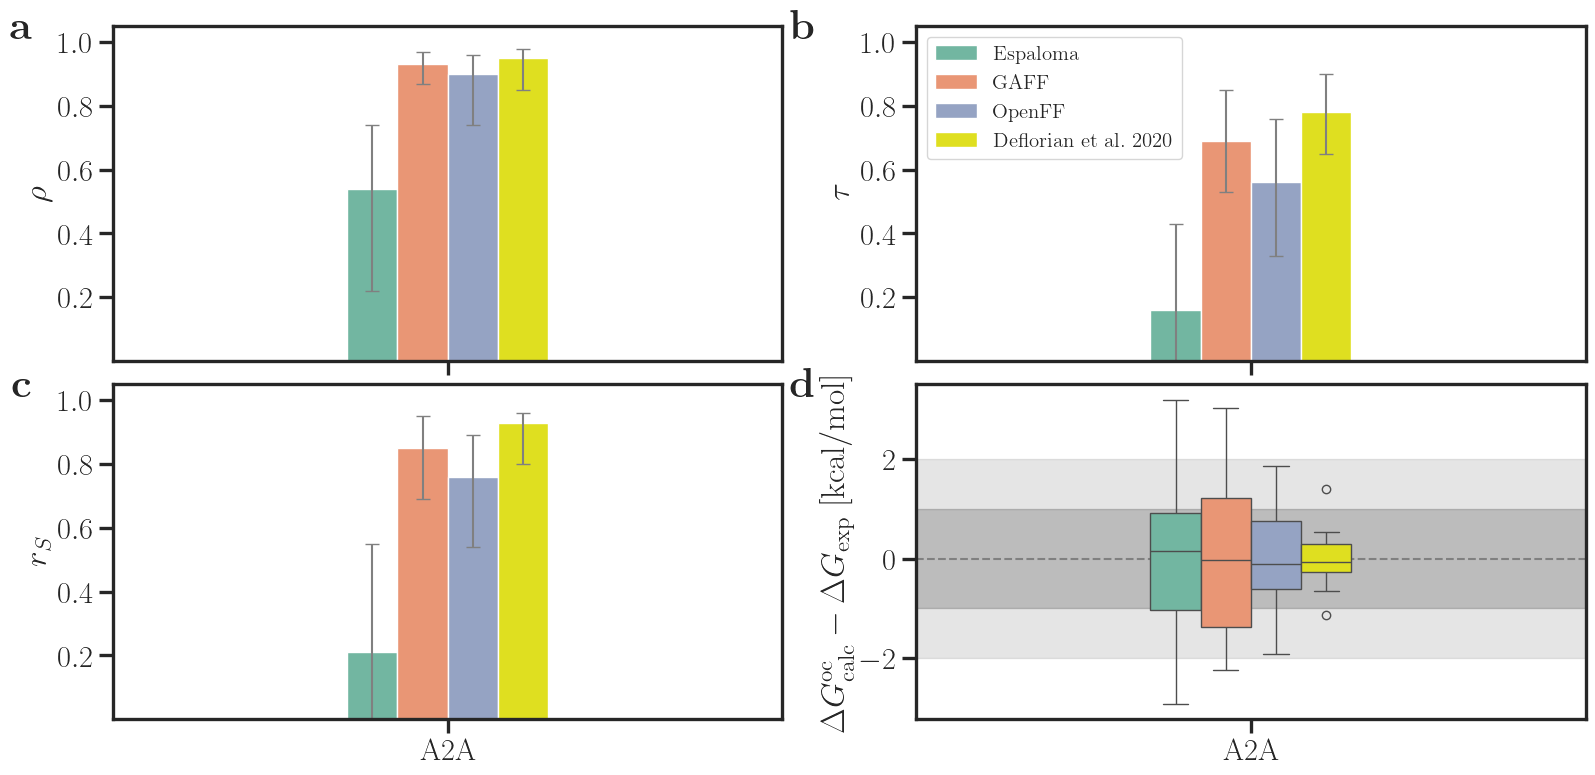

In [ ]:
scale = 2  
sns.set_theme(
    style="ticks", 
    font_scale=scale,
    rc={
        "axes.linewidth": 1.2 * scale,
        # "lines.linewidth": 1.1 * scale
        }
)

# Make ticks thicker/longer in proportion to font scaling
plt.rcParams.update({
    "xtick.major.size": 5 * scale,   # length of major ticks
    "ytick.major.size": 5 * scale,
    "xtick.major.width": 1.2 * scale,  # thickness of major ticks
    "ytick.major.width": 1.2 * scale,
})
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(19, 9), sharex=True)

plot_stats(ax=axs[0,0],data=stats_data, contribution='pearson', legend=None)

plot_stats(ax=axs[0,1],data=stats_data, contribution='kendall', legend="auto")

plot_stats(ax=axs[1,0],data=stats_data, contribution='spearman', legend=None)

axs[0, 1].sharey(axs[0, 0])
axs[1, 0].sharey(axs[0, 0])

axs[0,0].set(ylim=[0,1.05])
axs[0,0].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
axs[0,1].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
axs[1,0].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])


axs[1,1].axhline(0, color='gray', linestyle='--')

plot_range = [-1*v for v in range(5, 1, -1)] + list(range(15))
axs[1,1].fill_between(plot_range, -1, 1, color='black', alpha=0.2,)#label=r'$\pm 1 \mathrm{~kcal/mol}$')
axs[1,1].fill_between(plot_range, -2, 2, color='gray', alpha=0.2,)#label=r'$\pm 2 \mathrm{~kcal/mol}$')


plot_ff(ax=axs[1,1], data=diff_data,contribution='diff', legend=None)
axs[0,1].get_legend().set_title(None)
axs[0,1].legend(ncol=1, loc='best', fontsize=15)  # Adjust legend position if needed

# Add subplot labels
labels = ['a', 'b', 'c', 'd']
for ax, label in zip(axs.flat, labels):
    if label in ['b', 'd']:
        if any(axs[1,1].get_yticks() <= -10):
            x_position = -0.2
            wspace = 0.25
        else:
            x_position = -0.15
            wspace = 0.2
    else:
        x_position = -0.12
    
    ax.text(x_position, 1.05, f"$\\mathbf{{{label}}}$", transform=ax.transAxes, 
            fontsize=30, va='top', ha='right')

fig.subplots_adjust(wspace=wspace, hspace=0.07)

fig.savefig('summary/external/mbar-stats-A2A-validation.pdf',
            bbox_inches="tight",
            pad_inches=0.05,
            transparent=False)
